**Imports**

In [163]:
import os
import torch

import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import torch.utils.data
from torch.utils.data import DataLoader

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [164]:
NUM_WORKERS = os.cpu_count()
print("Number of workers: ", NUM_WORKERS)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

Number of workers:  2
Device:  cuda:0


**Data augmentation**

In [165]:
class GaussianBlur(object):
    """
    Blurs the given image with separable convolution as described in the SimCLR paper
    (ArXiv, https://arxiv.org/abs/2002.05709).
    """

    def __init__(self, kernel_size, p=0.5, min=0.1, max=2.0):
        self.min = min
        self.max = max

        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size
        self.p = p

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        # less than 50%
        if prob < self.p:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample


class simCLR_training_data_augmentation():
    """
    Implementation of the data augmentations on the trainig data
    as proposed in the SimCLR official paper
    """

    def __init__(
        self,
        size: int = 32,
        gaussian_blur: bool = False,
        jitter_strength: float = 1.,
        normalize = transforms.Normalize(mean=(0,), std=(1,)) # Default Normalization
    ):
        self.jitter_strength = jitter_strength
        self.size = size
        self.gaussian_blur = gaussian_blur
        self.normalize = normalize

        self.color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength, 
            0.8 * self.jitter_strength, 
            0.2 * self.jitter_strength
        )

        data_transforms = [
            transforms.Resize(self.size),
            transforms.RandomResizedCrop(size=self.size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([self.color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ]

        # Adding Gaussian blur
        if self.gaussian_blur:
            data_transforms.append(GaussianBlur(kernel_size=int(0.1 * self.size), p=0.5))

        data_transforms.append(transforms.ToTensor())

        # Adding Normalization
        data_transforms.append(self.normalize)

        # Transformations on the training data
        self.train_transform = transforms.Compose(data_transforms)

    def __call__(self, z):
        z_i = self.train_transform(z)
        z_j = self.train_transform(z)

        return z_i, z_j


class simCLR_eval_data_augmentation():
    """
    Implementation of the data augmentations on the testing data
    as proposed in the SimCLR official paper
    """

    def __init__(
        self,
        size: int = 32,
        crop: bool = False,
        normalize = transforms.Normalize(mean=(0,), std=(1,)) # Default Normalization
    ):
        self.size = size
        self.crop = crop
        self.normalize = normalize

        data_transforms = [
            transforms.Resize(self.size)
        ]

        # Adding Crop
        if self.crop:
            data_transforms.append(transforms.RandomResizedCrop(size=self.size))
        
        data_transforms.append(transforms.ToTensor())

        # Adding Normalization
        data_transforms.append(self.normalize)

        # Transformations on the testing data
        self.test_transform = transforms.Compose(data_transforms)

    def __call__(self, z):
        z_i = self.test_transform(z)
        z_j = self.test_transform(z)

        return z_i, z_j

**Datasets and Configurations**

In [166]:
# Paths
cifar10_path = '/data/CIFAR-10-augmented'
cifar100_path = '/data/CIFAR-100-augmented'

# Batch size
BATCH_SIZE = 128

# CIFAR-10
cifar10_trainset = datasets.CIFAR10(
    root=cifar10_path, train=True, download=True, transform=simCLR_training_data_augmentation(normalize=transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))))
cifar10_trainloader = DataLoader(
    cifar10_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

cifar10_testset = datasets.CIFAR10(
    root=cifar10_path, train=False, download=True, transform=simCLR_eval_data_augmentation(crop=True))
cifar10_testloader = DataLoader(
    cifar10_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# CIFAR-100
cifar100_trainset = datasets.CIFAR100(
    root=cifar100_path, train=True, download=True, transform=simCLR_training_data_augmentation(gaussian_blur=True, 
    normalize=transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))))
cifar100_trainloader = DataLoader(
    cifar100_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

cifar100_testset = datasets.CIFAR100(
    root=cifar100_path, train=False, download=True, transform=simCLR_eval_data_augmentation(crop=True))
cifar100_testloader = DataLoader(
    cifar100_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**CIFAR-10 Preview Photos**

CIFAR-10 Trainset shape:  (50000, 32, 32, 3)
CIFAR-10 Testset shape:  (10000, 32, 32, 3)


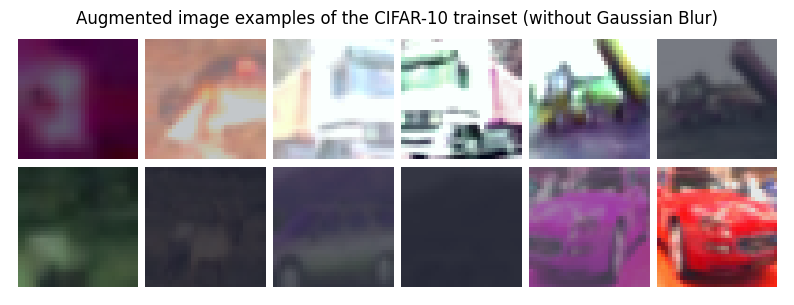

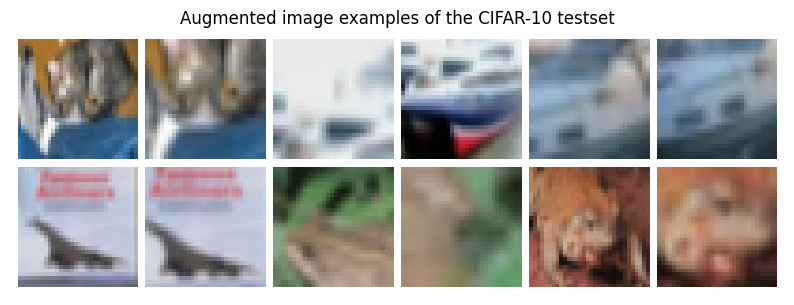

In [167]:
print("CIFAR-10 Trainset shape: ", cifar10_trainset.data.shape)
print("CIFAR-10 Testset shape: ", cifar10_testset.data.shape)

# Number of images
NUM_IMAGES = 6

# Trainset images
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in cifar10_trainset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=1.0)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the CIFAR-10 trainset (without Gaussian Blur)")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

# Testset images
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in cifar10_testset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=1.0)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the CIFAR-10 testset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

**CIFAR-100 Preview Photos**

CIFAR-100 Trainset shape:  (50000, 32, 32, 3)
CIFAR-100 Testset shape:  (10000, 32, 32, 3)


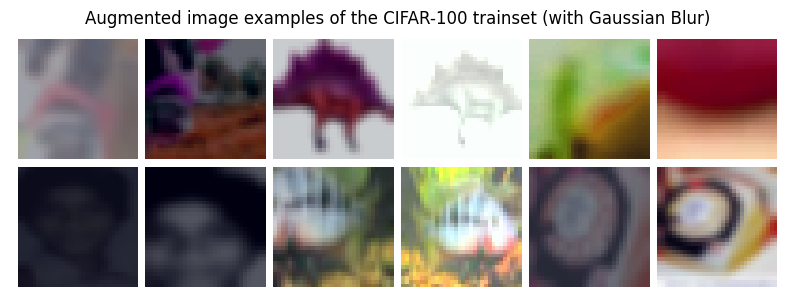

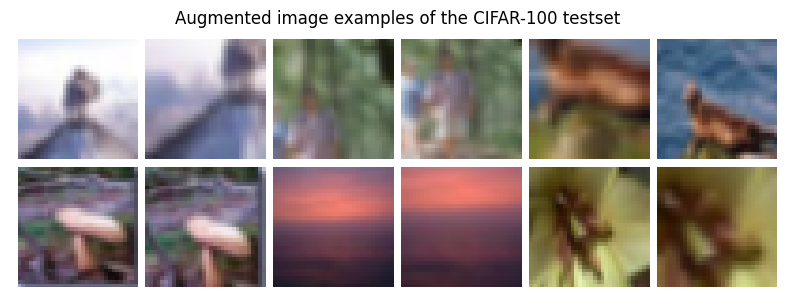

In [168]:
print("CIFAR-100 Trainset shape: ", cifar100_trainset.data.shape)
print("CIFAR-100 Testset shape: ", cifar100_testset.data.shape)

# Number of images
NUM_IMAGES = 6

# Trainset images
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in cifar100_trainset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=1.0)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the CIFAR-100 trainset (with Gaussian Blur)")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

# Testset images
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in cifar100_testset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=1.0)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the CIFAR-100 testset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()